Robert Flanagan 21311625 Cathal Crowe 21320128

The code executes to the end without error.

The original source of dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Define hyperparameters
epochs = 100         # The model seems to level out around 50 epochs with diminishing returns there after but as the validation loss does not grow we decided to leave the epochs at 100 to get a better visualisation of the model
batch_size = 64      # Lower batch size (e.g., 32) increases the noise in each update and improves the model's performance but leads to overfitting. Higher batch sizes lead to the model performing worse
verbose = 1          # Set to 1 to allow us to keep track of the model's performance over time
n_hidden = 128       # Increasing this value leads to a big increase in the model's performance but worsens the overfitting problem. Decreasing the value worsens performance
learning_rate = 0.01 # 0.01 seems to be a sweet spot for preventing overfitting lower learning rate worsens performance
dropout_rate = 0.3   # Dropout rate of 0.3 is needed to prevent any overfitting, 0.2 and 0.1 were both sampled with a range of different hyper paramenters but the overfitting remained, Higher dropout rate degrades results without any benefit
n_splits = 5         # We use 5 folds to ensure the results stay more consistent on each run-through

In [2]:
#This code block is responsible for reading the dataset

# Loads the CSV files that contain the wine data
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# Combines the red and white wine data
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# Makes one data set that contains all the data except the quality for training purposes
X = wine_data.drop(columns=['quality'])
# Creates a data set that only contains quality that is then compared with the models predictions to determine accuarcy
y = wine_data['quality']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Create a heatmap of feature correlations
plt.figure(figsize=(12, 10))
correlation_matrix = wine_data.corr()  # Calculate correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()


In [4]:
#This code block is responsible for creating and running the model aswell as storing all relevant data

# Initialize K-Fold cross-validation using our hyper parameter for n_splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store our accuracy values
training_losses = []  # Stores training losses for each fold
validation_losses = []  # Stores validation losses for each fold
y_val_list = []  # Stores validation labels for confusion matrix
y_pred_list = []  # Stores predictions for confusion matrix

# Initialize lists to store epoch-wise accuracy for each fold
epoch_accuracy_lists = [[] for _ in range(n_splits)]  # Accuracy for each fold
epoch_off_by_one_accuracy_lists = [[] for _ in range(n_splits)]  # Off-by-one accuracy for each fold

for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Build the MLP model
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Adding hidden layers with dropout
    for _ in range(2):  # Number of hidden layers
        model.add(layers.Dense(n_hidden, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))  # Regression output

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # Define custom callback to save accuracy after each epoch
    class AccuracyCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            # Predict and calculate accuracy after each epoch
            y_pred = self.model.predict(X_val)
            y_pred_rounded = tf.round(y_pred).numpy().flatten()  # Convert predictions to 1D NumPy array

            # Calculate accuracy
            accuracy = accuracy_score(y_val, y_pred_rounded)

            # Calculate off-by-one accuracy
            off_by_one_accuracy = sum(
                (y_pred_rounded == y_val.to_numpy()) |
                (y_pred_rounded + 1 == y_val.to_numpy()) |
                (y_pred_rounded - 1 == y_val.to_numpy())
            ) / len(y_val)

            # Append metrics to the fold-specific lists
            epoch_accuracy_lists[fold_idx].append(accuracy)
            epoch_off_by_one_accuracy_lists[fold_idx].append(off_by_one_accuracy)

    # Train the model with the custom callback
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        callbacks=[AccuracyCallback()])  # Add the custom callback

    # Store training and validation losses
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])

    # Store the validation labels and predictions for confusion matrix
    y_val_list.extend(y_val)
    y_pred = model.predict(X_val)
    y_pred_rounded = tf.round(y_pred).numpy().flatten()
    y_pred_list.extend(y_pred_rounded)

# Calculate mean losses across all folds
mean_training_loss = [sum(x) / n_splits for x in zip(*training_losses)]
mean_validation_loss = [sum(x) / n_splits for x in zip(*validation_losses)]

# Calculate mean accuracy and off-by-one accuracy across all folds for each epoch
mean_epoch_accuracy = [sum(epoch_accuracies) / n_splits for epoch_accuracies in zip(*epoch_accuracy_lists)]
mean_epoch_off_by_one_accuracy = [sum(epoch_off_by_ones) / n_splits for epoch_off_by_ones in zip(*epoch_off_by_one_accuracy_lists)]

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8696 - mae: 1.7746 - val_loss: 0.9132 - val_mae: 0.7329
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2935 - mae: 0.8950 - val_loss: 1.2761 - val_mae: 0.9201
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2738 - mae: 0.8854 - val_loss: 0.5848 - val_mae: 0.5911
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8543 - mae: 0.7157 - val_loss: 0.5919 - val_mae: 0.5932
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8318 - mae: 0.7155 - val_loss: 0.5531 - val_mae: 0.5772
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7904 - mae: 0.6902 - val_loss: 0.5215 - val_mae: 0.5618
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
82/82 ━━━

In [ ]:
#This code block is used for plotting all of our performance graphs

# Plotting the mean average training and validation losses across all folds
plt.figure(figsize=(10, 5))
plt.plot(mean_training_loss, label='Mean Training Loss', color='blue')
plt.plot(mean_validation_loss, label='Mean Validation Loss', color='orange', linestyle='--')
plt.title('Mean Training and Validation Loss Across All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting mean average accuracy and off-by-one accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(mean_epoch_accuracy, label='Mean Accuracy', color='blue')
plt.plot(mean_epoch_off_by_one_accuracy, label='Mean Off-by-One Accuracy', color='orange', linestyle='--')
plt.title('Mean Accuracy and Off-by-One Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
plt.legend()
plt.grid()
plt.show()

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val_list, y_pred_list)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Quality')
plt.ylabel('True Quality')
plt.show()


# **1. The Data Set**
Our data set is composed of two CVSs, one for white wine and one for red wine. Both CVSs contain numeric data for all the features of the wine such as alcohol content, pH level, and sugar content. All these wines also have a rating applied to them from 1-10 (although only values as low as 3 and as high as 9 are actually present in the dataset). We hide the quality rating from our model and set it as a target for the model to predict.  

We visual this data using a heatmap. This allows us to get insight into how the different features of the wine relate to one another.  In this map we can see a few expected results such as higher alcohol content being inversely related to density due to alcohol being less dense than water and citric acid being inversely related to pH as acids are lower on the pH scale. This heatmap can be seen in the code block outputs above as well below in this text box

We also use StandardScaler() to normalize the data to make sure all features are on a comparable scale this helps improve the performance during training  

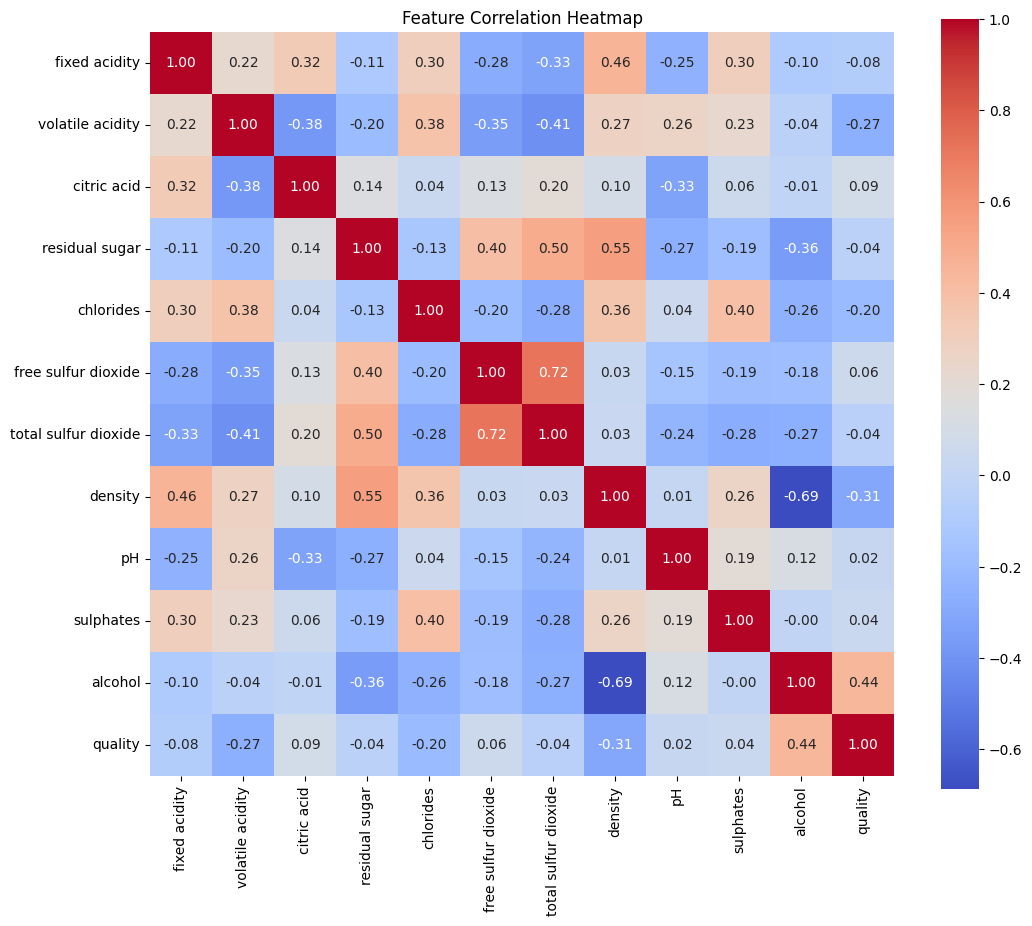

# **2. The Network Structure and Other Hyperparameters**

This is a fully connected multi-layer perceptron with two hidden layers. The hyperparameters we examined to maximise our performance were epochs, batch size, neurons in the hidden layer, learning rate, dropout, and number of folds for our k fold validation.

# **3. The Cost / Loss / Error / Objective Function, and the Optimiser**

We chose to use mean squared error (MSE) as our loss function because it is the most suitable for a regression task like predicting wine quality. We use the Adam optimiser as it was giving us the best results without causing overfitting.




# **4. Cross Fold Validation**

We split our data into 5 folds for cross validation this helped us ensure the model was able to respond well to diverse kinds of unseen data it also helped make the results more consistent on each run-through as the model was being tested more thoroughly

# **5. Results**
For each fold and epoch we calculated the accuracy (how often the model guessed the exact right quality rating) and off by one accuracy (how often the model guessed either the exact accuracy or 1 score above/below) we mapped these accuracies on a graph over epochs to show how the model improved the more it trained we also added a confusion matrix for an easy way to see the models predictions to enable us to evaluate what areas the models performance was at its best/worst. These graphs can be seen in the code block outputs above as well below in this text box


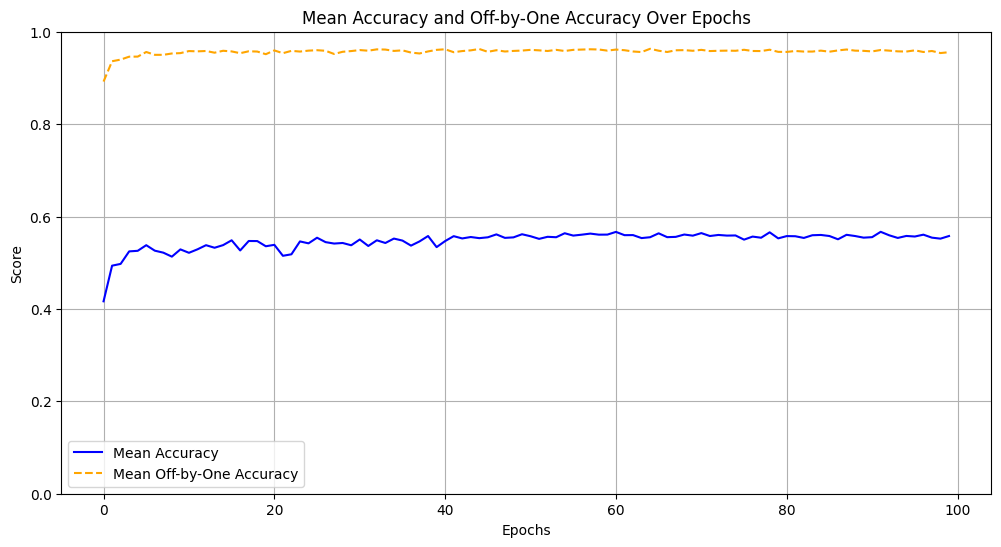


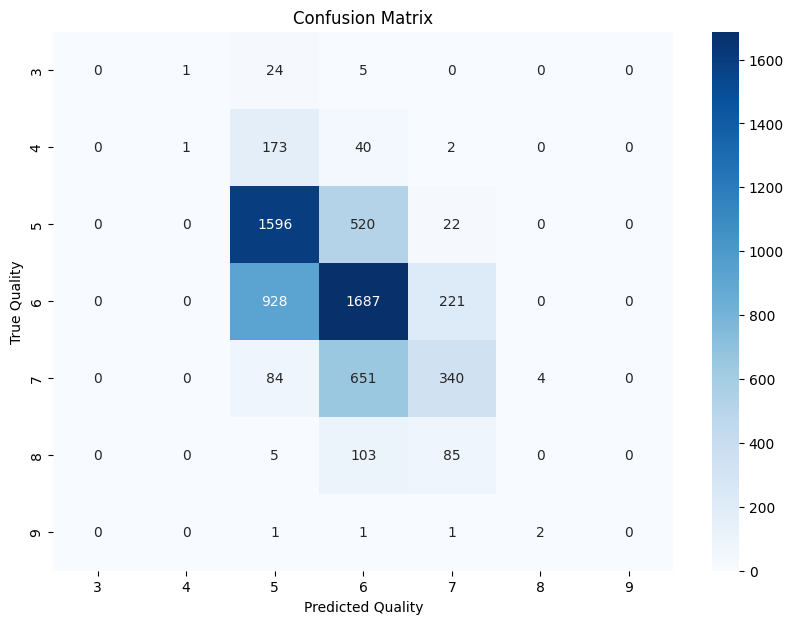

# **6. Evaluation of the Results**

We can determine that our model performs at an acceptable level of approximately 60% accuracy at predicting the exact quality of the wine and at an accuracy >95% for predicting the off-by-one accuracy.

The model also appears to perform particularly poorly when predicting wines of qualities 3 and 9, due to the limited number of samples in our dataset matching the respective qualities.

While these results might seem underwhelming, through analyzing the data, we believe that there is not a very strong correlation between the quality rating of the wine against the wine parameters. The quality rating is seemingly somewhat randomly orientated, likely due to the fact that the quality ratings were provided by a human reviewing the wines.

# **7. Impact of Varying Hyperparameter(s)**

epochs = 100 - The model seems to level out at around 50 epochs with diminishing returns there after but as the validation loss does not grow we decided to leave the epochs at 100 to get a better overall visualisation of the model's improvement

batch_size = 64 - Lower batch size (e.g. 32) increases the noise in each update and improves the model's performance but leads to overfitting. Higher batch sizes lead to the model performing worse, 64 appears to be the sweet spot.

verbose = 1 - Set to 1 to allow us to keep track of the model's performance over time

n_hidden = 128 - Increasing this value leads to a big increase in the model's performance but worsens the overfitting problem. Decreasing the value worsens performance. We found 128 to be the perfect balance

learning_rate = 0.01 - 0.01 seems to be a sweet spot for preventing overfitting lower learning rate worsens performance.

dropout_rate = 0.3 - Dropout rate of 0.3 is needed to prevent any overfitting, 0.2 and 0.1 were both sampled with a range of different hyper paramenters but the overfitting remained, Higher dropout rate degrades results without any benefit.

n_splits = 5 - We use 5 folds to ensure the results are consistent across unseen data. This consistency allows us to determine that our model is generalized and will perform just as well on unseen data.